In [2]:
import os, sys
import os.path as osp
root_dir = osp.dirname(osp.dirname(os.getcwd()))
package_dir = osp.join(root_dir, 'src')
sys.path.append(package_dir)
from ml_modules.data.datasets import DeepSTABp_Dataset
from ml_modules.data.transforms import norm_0to1

import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'figure.autolayout': True})

dataset = DeepSTABp_Dataset(
    experiment='lysate',
    organism=None,
    cell_line=None,
    version='v5-sigma2_cutoff12_species',
    transform=None
)
dataset_trans = DeepSTABp_Dataset(
    experiment='lysate',
    organism=None,
    cell_line=None,
    version='v5-sigma2_cutoff12_species',
    transform=norm_0to1
)
Tm_dict = dataset.Tm_dict

species2idx = {
    "Oleispira antarctica": 0,
    "Caenorhabditis elegans": 1,
    "Arabidopsis thaliana": 2,
    "Drosophila melanogaster": 3,
    "Danio rerio": 4,
    "Saccharomyces cerevisiae": 5,
    "Bacillus subtilis": 6,
    "Escherichia coli": 7,
    "Homo sapiens": 8,
    "Mus musculus": 9,
    "Geobacillus stearothermophilus": 10,
    "Picrophilus torridus": 11,
    "Thermus thermophilus": 12
}
cm = plt.get_cmap('gist_rainbow')

edge_types = ['backbone', 'codir', 'pae', 'coord', 'contact', 'deform']

 -> Generating dataset from c:\Users\yenlin\Dropbox\projects\ai-thermostability\code\data\collation\DeepSTABp\lysate.csv
 -> Number of entries in meta file    : 29757
     >> mean value of Tm  : 49.8242
     >> range of Tm       : 30.4417-92.5729
 -> Number of unique accessions       : 29757
 -> Final number of accessions        : 20255
     >> mean value of Tm: 50.4288
     >> range of Tm     : 30.4417-92.5729
 -> Number of unique accessions       : 20255
Dataset instantiation complete.
 -> Generating dataset from c:\Users\yenlin\Dropbox\projects\ai-thermostability\code\data\collation\DeepSTABp\lysate.csv
 -> Number of entries in meta file    : 29757
     >> mean value of Tm  : 49.8242
     >> range of Tm       : 30.4417-92.5729
 -> Number of unique accessions       : 29757
 -> Final number of accessions        : 20255
     >> mean value of Tm: 50.4288
     >> range of Tm     : 30.4417-92.5729
 -> Number of unique accessions       : 20255
Dataset instantiation complete.


In [3]:
# GATHER ALL REQUIRED INFORMATION

all_Tm = []
all_ogt = []
all_species = []
all_seq_length = []
pLDDT_by_protein = []
bfactors_by_protein = []
edge_count = {edge_type: [] for edge_type in edge_types}

pbar = tqdm(dataset)
for i, data in enumerate(pbar):
    pbar.set_description(data['accession'])

    all_Tm.append(Tm_dict[data['accession']])
    all_ogt.append(data.ogt)
    all_species.append(data.species)
    all_seq_length.append(data['residue'].num_nodes)
    pLDDT_by_protein.append(data['residue'].pLDDT.tolist())
    bfactors_by_protein.append(data['residue'].bfactor.tolist())
    
    for edge_type in edge_types:
        edge_count[edge_type].append(
            data['residue', edge_type, 'residue'].edge_index.shape[1]/2
        )

all_pLDDT = [e for protein in pLDDT_by_protein for e in protein]
all_bfactors = [e for protein in bfactors_by_protein for e in protein]

all_pLDDT_mean = [np.mean(e) for e in pLDDT_by_protein]
all_pLDDT_max = [np.max(e) for e in pLDDT_by_protein]
all_pLDDT_min = [np.min(e) for e in pLDDT_by_protein]
all_bfactor_mean = [np.mean(e) for e in bfactors_by_protein]
all_bfactor_max = [np.max(e) for e in bfactors_by_protein]
all_bfactor_min = [np.min(e) for e in bfactors_by_protein]

  0%|          | 0/20255 [00:00<?, ?it/s]

In [4]:
# sort entries by ogt

sorted_idx = np.argsort(all_ogt)

all_Tm = np.array(all_Tm)[sorted_idx]
all_ogt = np.array(all_ogt)[sorted_idx]
all_species = np.array(all_species)[sorted_idx]
all_seq_length = np.array(all_seq_length)[sorted_idx]

pLDDT_by_protein = [pLDDT_by_protein[i] for i in sorted_idx]
bfactors_by_protein = [bfactors_by_protein[i] for i in sorted_idx]

edge_count = {
    edge_type: np.array(edge_count[edge_type])[sorted_idx]
    for edge_type in edge_types
}

all_pLDDT_mean = np.array(all_pLDDT_mean)[sorted_idx]
all_pLDDT_max = np.array(all_pLDDT_max)[sorted_idx]
all_pLDDT_min = np.array(all_pLDDT_min)[sorted_idx]
all_bfactor_mean = np.array(all_bfactor_mean)[sorted_idx]
all_bfactor_max = np.array(all_bfactor_max)[sorted_idx]
all_bfactor_min = np.array(all_bfactor_min)[sorted_idx]

In [5]:
from scipy.stats import kurtosis

print(all_seq_length.min(), all_seq_length.max())
print(np.mean(all_seq_length))
print(np.std(all_seq_length))
print(np.std(all_seq_length)**2)
print(kurtosis(all_seq_length))

20 695
333.79195260429526
132.5914469113288
17580.491794039724
-0.8734479514655824


In [6]:
print(all_Tm.min(), all_Tm.max())
print(np.mean(all_Tm))
print(np.std(all_Tm))
print(np.std(all_Tm)**2)
print(kurtosis(all_Tm))

30.441673997070385 92.57285069068394
50.428816244695554
9.720422898776004
94.4866213310489
3.380139579951682


In [7]:
for edge_type in edge_count:
    print(edge_type)
    print(edge_count[edge_type].min(), edge_count[edge_type].max())
    print(np.mean(edge_count[edge_type]))
    print(np.std(edge_count[edge_type]))
    # print(np.std(edge_count[edge_type])**2)
    # print(kurtosis(edge_count[edge_type]))
    print()

backbone
19.0 694.0
332.79195260429526
132.5914469113288

codir
2.0 84523.0
12045.094050851641
13231.882306664815

pae
42.0 157216.0
30652.128807701803
26751.20365370254

coord
1.0 33968.0
2816.438410269069
3227.0375260317355

contact
103.0 10615.0
4331.238212786966
2054.3016931222664

deform
11.0 13127.0
2051.879437176006
1628.9459255959678



In [8]:
uni, cnt = np.unique(all_species, return_counts=True)

for i in range(len(uni)):
    species_Tm = all_Tm[all_species == uni[i]]
    print(uni[i])
    print(np.mean(species_Tm))
    print(np.std(species_Tm))
    print(cnt[i])
    print()

Arabidopsis thaliana
45.10652683135525
4.881811566914626
1594

Bacillus subtilis
44.28218499309456
3.8712453840166137
1173

Caenorhabditis elegans
41.369561163758014
4.4746278958623895
2063

Danio rerio
52.10384409188695
4.324837496284524
118

Drosophila melanogaster
42.99666853063006
3.3927502596564776
907

Escherichia coli
50.34001752908471
5.842032152937796
1386

Geobacillus stearothermophilus
69.56660748147539
5.0219513134775315
555

Homo sapiens
51.425530703167446
3.8542094067477777
4620

Mus musculus
50.352817199953535
3.735913972755317
4188

Oleispira antarctica
42.01433333327658
3.9240673407796267
886

Picrophilus torridus
72.02479748701445
4.811803077309313
755

Saccharomyces cerevisiae
49.352556430327915
3.9725959432369033
1430

Thermus thermophilus
82.89546684198976
5.452876929728156
580



In [20]:
save = True

  0%|          | 0/6 [00:00<?, ?it/s]

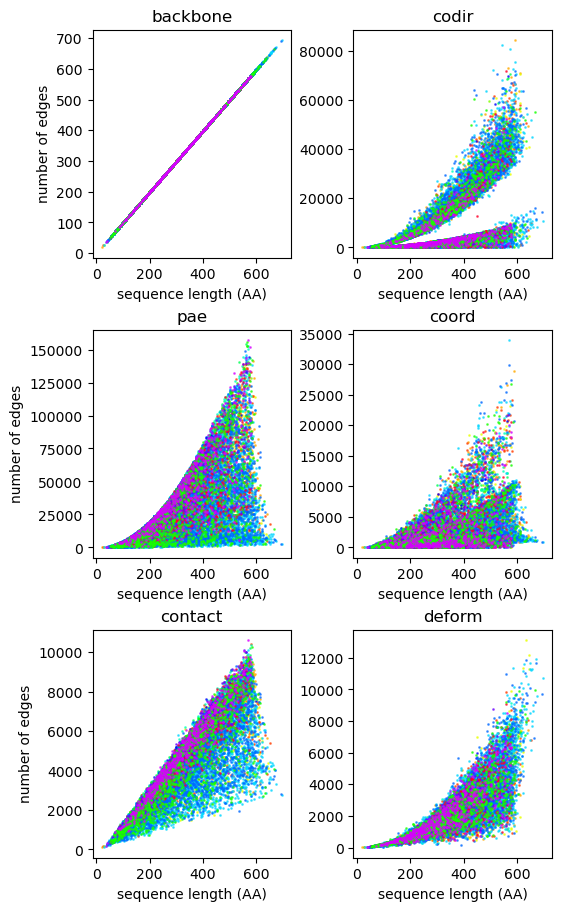

In [21]:
# seq length vs edge counts

fig, ax = plt.subplots(
    3, 2, sharex=True, sharey=False, figsize=(5.5,9), layout='compressed'
)
ax = ax.flatten()

pbar = tqdm(edge_types)
for i, edge_type in enumerate(pbar):
    pbar.set_description(edge_type)

    for species in np.unique(all_species):
        ax[i].scatter(
            all_seq_length[all_species==species],
            edge_count[edge_type][all_species==species],
            color=cm(species2idx[species]/len(species2idx)),
            s=1,
            alpha=0.6
        )
    
    ax[i].set_title(edge_type)

    ax[i].tick_params(labelbottom=True)
    ax[i].set_xlabel('sequence length (AA)')
    if i%2 == 0:
        ax[i].set_ylabel('number of edges')

if save:
    plt.savefig('seq_length_vs_edge_count.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

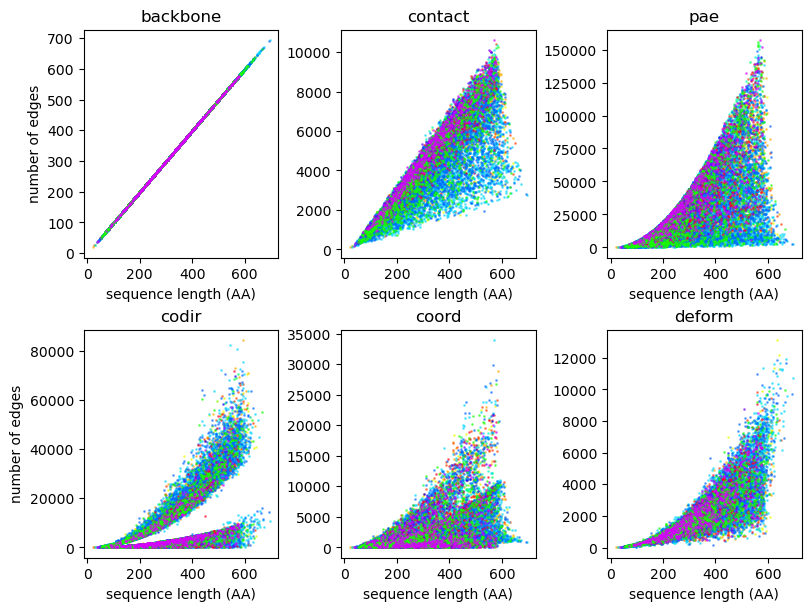

In [22]:
# seq length vs edge counts

fig, ax = plt.subplots(
    2, 3, sharex=True, sharey=False, figsize=(8,6), layout='compressed'
)
ax = ax.flatten()

pbar = tqdm(['backbone', 'contact', 'pae', 'codir', 'coord', 'deform'])
for i, edge_type in enumerate(pbar):
    pbar.set_description(edge_type)

    for species in np.unique(all_species):
        ax[i].scatter(
            all_seq_length[all_species==species],
            edge_count[edge_type][all_species==species],
            color=cm(species2idx[species]/len(species2idx)),
            s=1,
            alpha=0.5
        )
    
    ax[i].set_title(edge_type)

    ax[i].tick_params(labelbottom=True)
    ax[i].set_xlabel('sequence length (AA)')
    if i%3 == 0:
        ax[i].set_ylabel('number of edges')

if save:
    plt.savefig('seq_length_vs_edge_count-horizontal.png', dpi=300)
plt.show()
plt.close()

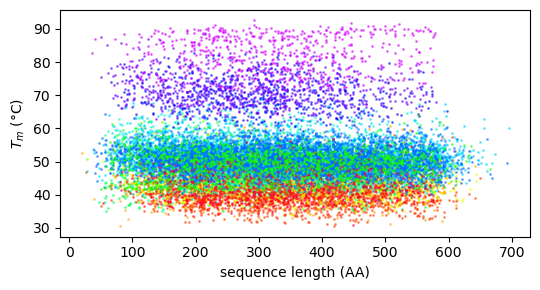

In [29]:
# seq length vs Tm

plt.figure(figsize=(5.5, 3))

for species in np.unique(all_species):
    plt.scatter(
        all_seq_length[all_species==species],
        all_Tm[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )

plt.xlabel('sequence length (AA)')
plt.ylabel(r'$T_m$ (°C)')
# plt.grid()
if save:
    plt.savefig('seq_length_vs_Tm.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

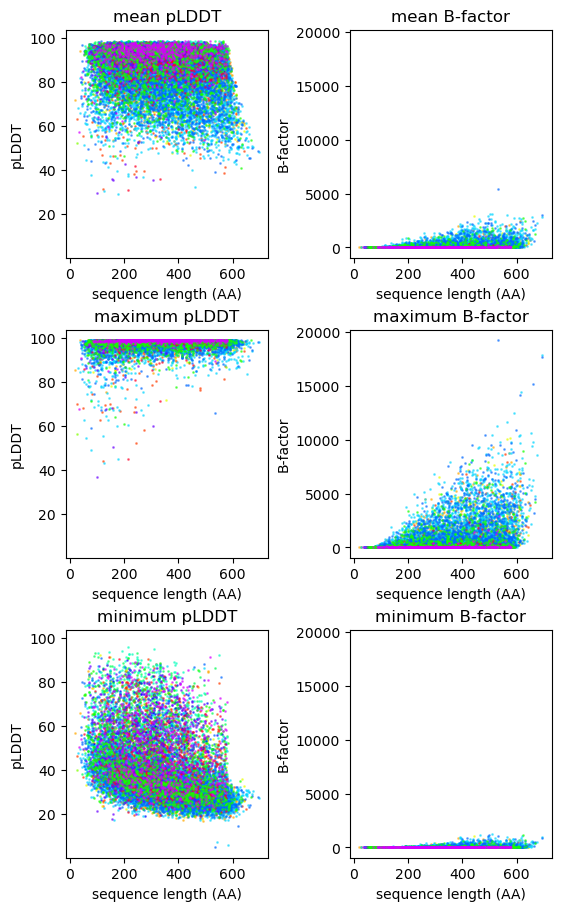

In [24]:
# seq length vs pLDDT / B-factor

fig, ax = plt.subplots(
    3, 2, sharex=True, sharey='col', figsize=(5.5, 9), layout='compressed'
)
ax = ax.flatten()

### pLDDT MEAN
for species in np.unique(all_species):
    ax[0].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_mean[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[0].set_title('mean pLDDT')
ax[0].set_xlabel('sequence length (AA)')
ax[0].set_ylabel('pLDDT')
ax[0].tick_params(labelbottom=True)

### B-FACTOR MEAN
for species in np.unique(all_species):
    ax[1].scatter(
        all_seq_length[all_species==species],
        all_bfactor_mean[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[1].set_title('mean B-factor')
ax[1].set_xlabel('sequence length (AA)')
ax[1].set_ylabel('B-factor')
ax[1].tick_params(labelbottom=True)

### pLDDT MAX
for species in np.unique(all_species):
    ax[2].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_max[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[2].set_title('maximum pLDDT')
ax[2].set_xlabel('sequence length (AA)')
ax[2].set_ylabel('pLDDT')
ax[2].tick_params(labelbottom=True)

### B-FACTOR MAX
for species in np.unique(all_species):
    ax[3].scatter(
        all_seq_length[all_species==species],
        all_bfactor_max[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[3].set_title('maximum B-factor')
ax[3].set_xlabel('sequence length (AA)')
ax[3].set_ylabel('B-factor')
ax[3].tick_params(labelbottom=True)

### pLDDT MIN
for species in np.unique(all_species):
    ax[4].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_min[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[4].set_title('minimum pLDDT')
ax[4].set_xlabel('sequence length (AA)')
ax[4].set_ylabel('pLDDT')

### B-FACTOR MIN
for species in np.unique(all_species):
    ax[5].scatter(
        all_seq_length[all_species==species],
        all_bfactor_min[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.5
    )
ax[5].set_title('minimum B-factor')
ax[5].set_xlabel('sequence length (AA)')
ax[5].set_ylabel('B-factor')

if save:
    plt.savefig('seq_len_vs_pLDDT_bfactor.png', dpi=300)#, bbox_inches='tight')
plt.show()
plt.close()

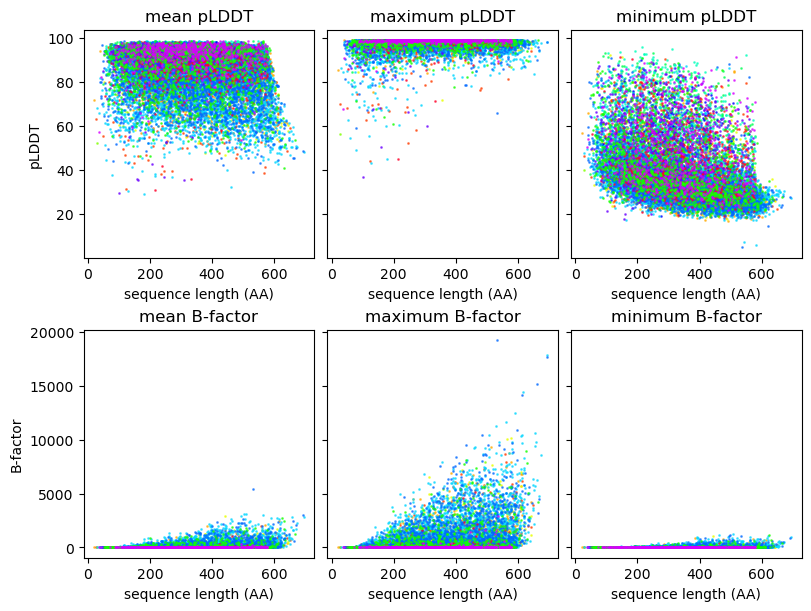

In [25]:
# seq length vs pLDDT / B-factor

fig, ax = plt.subplots(
    2, 3, sharex=True, sharey='row', figsize=(8, 6), layout='compressed'
)
ax = ax.flatten()

### pLDDT MEAN
for species in np.unique(all_species):
    ax[0].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_mean[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[0].set_title('mean pLDDT')
ax[0].set_xlabel('sequence length (AA)')
ax[0].set_ylabel('pLDDT')
ax[0].tick_params(labelbottom=True)

### B-FACTOR MEAN
for species in np.unique(all_species):
    ax[1].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_max[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[1].set_title('maximum pLDDT')
ax[1].set_xlabel('sequence length (AA)')
# ax[1].set_ylabel('pLDDT')
ax[1].tick_params(labelbottom=True)

### pLDDT MAX
for species in np.unique(all_species):
    ax[2].scatter(
        all_seq_length[all_species==species],
        all_pLDDT_min[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[2].set_title('minimum pLDDT')
ax[2].set_xlabel('sequence length (AA)')
# ax[2].set_ylabel('pLDDT')
ax[2].tick_params(labelbottom=True)

### B-FACTOR MAX
for species in np.unique(all_species):
    ax[3].scatter(
        all_seq_length[all_species==species],
        all_bfactor_mean[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[3].set_title('mean B-factor')
ax[3].set_xlabel('sequence length (AA)')
ax[3].set_ylabel('B-factor')
ax[3].tick_params(labelbottom=True)

### pLDDT MIN
for species in np.unique(all_species):
    ax[4].scatter(
        all_seq_length[all_species==species],
        all_bfactor_max[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[4].set_title('maximum B-factor')
ax[4].set_xlabel('sequence length (AA)')
# ax[4].set_ylabel('B-factor')

### B-FACTOR MIN
for species in np.unique(all_species):
    ax[5].scatter(
        all_seq_length[all_species==species],
        all_bfactor_min[all_species==species],
        color=cm(species2idx[species]/len(species2idx)),
        s=1,
        alpha=0.6
    )
ax[5].set_title('minimum B-factor')
ax[5].set_xlabel('sequence length (AA)')
# ax[5].set_ylabel('B-factor')

if save:
    plt.savefig('seq_len_vs_pLDDT_bfactor-horizontal.png', dpi=300)
plt.show()
plt.close()